Загружаем необходимые данные

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from random import randint
import torch
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler)

from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import (AutoTokenizer,
                          AutoModelForCausalLM,
                          Trainer,
                          TrainingArguments,
                          TrainerCallback,
                          AdamW,
                          get_linear_schedule_with_warmup)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda'
device = torch.device(device)

print(device.type)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [ ]:
!pip install chardet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import chardet
with open('/content/drive/MyDrive/Bert/2 STEP (название).csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Bert/2 STEP (название).csv', encoding='UTF-8-SIG', sep=';')
# Размер нашей выборки
df.shape

(105000, 3)

In [ ]:
df.sample(5)

,Unnamed: 0,name,category_1
75550,77636,России разрешили не выполнять обязательства ВТ...,Госэкономика
85971,47734,Соратник Порошенко призвал взрывать оппозицион...,Украина
42329,49681,Киевских чиновников уличили в миллионной растр...,Украина
25878,56390,Власти ДНР уличили Киев в подготовке масштабно...,Украина
67851,8113,Пострадавший в Киргизии альпинист поправился д...,Все


In [ ]:
df.category_1.unique()

array(['Все', 'Украина', 'Футбол', 'Общество', 'Политика', 'Происшествия',
       'Госэкономика'], dtype=object)

In [ ]:
# Присвоим каждой категории индекс, чтобы подавать в модель
category_index = {i[1]:i[0] for i in enumerate(df.category_1.unique())}
# обратное преобразование - индекс метки в текст, этот словарь нам понадобится 
# после обучения для большей наглядности, чтобы видеть, к какой категории товар 
# отнесён моделью
category_index_reverce = {i[0]:i[1] for i in enumerate(df.category_1.unique())}

In [ ]:
category_index

{'Все': 0,
 'Украина': 1,
 'Футбол': 2,
 'Общество': 3,
 'Политика': 4,
 'Происшествия': 5,
 'Госэкономика': 6}

In [ ]:
category_index_reverce

{0: 'Все',
 1: 'Украина',
 2: 'Футбол',
 3: 'Общество',
 4: 'Политика',
 5: 'Происшествия',
 6: 'Госэкономика'}

In [ ]:
# Переведём все метки датасета в числа
sentences = df.name.values
labels = [category_index[i] for i in df.category_1.values]

In [ ]:
# Каждому предложению (названию товара) теперь соответсвует не название категории, а её индекс:
sentences[22], labels[22]

(' а пять лет спустя был избран на второй срок. На посту президента в 2005 году его сменил Сергей Багапш. В ходе грузино-абхазского вооруженного конфликта Ардзинба руководил государственным комитетом обороны. Пост президента он занял в 1994 году',
 0)

In [ ]:
# Проверим, что все данные корректны
assert len(sentences) == len(labels) == df.shape[0]

In [ ]:
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [ ]:
train_sentences, test_sentences, train_category, test_category = train_test_split(sentences, labels, test_size=0.005)

In [ ]:
len(train_sentences), len(test_sentences)

(104475, 525)

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('"Out_Bert_Pretrained/checkpoint-2500"')

Some weights of the model checkpoint at /content/drive/MyDrive/Bert/Out_Bert_Finetuned were not used when initializing BertForMaskedLM: ['taskmodels_dict.clas.bert.encoder.layer.2.attention.output.LayerNorm.weight', 'taskmodels_dict.rumed.bert.encoder.layer.4.attention.self.query.weight', 'encoder.encoder.layer.11.output.LayerNorm.bias', 'encoder.encoder.layer.1.output.LayerNorm.weight', 'taskmodels_dict.rumed.bert.encoder.layer.11.output.dense.weight', 'taskmodels_dict.rumed.bert.encoder.layer.3.output.LayerNorm.weight', 'taskmodels_dict.rumed.bert.encoder.layer.5.attention.self.key.weight', 'taskmodels_dict.rumed.bert.encoder.layer.3.attention.output.LayerNorm.bias', 'taskmodels_dict.clas.bert.encoder.layer.3.attention.output.LayerNorm.bias', 'encoder.encoder.layer.8.output.LayerNorm.weight', 'taskmodels_dict.rumed.bert.encoder.layer.11.intermediate.dense.weight', 'encoder.encoder.layer.11.attention.self.query.weight', 'taskmodels_dict.rumed.bert.encoder.layer.0.output.dense.bias', '

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

In [ ]:
# Посмотрим, что получилось
print(tokenized_texts[42])

['[CLS]', 'р', '##о', '##с', '##с', '##ия', 'з', '##а', '##б', '##л', '##о', '##к', '##и', '##р', '##ов', '##а', '##л', '##а', 'р', '##е', '##з', '##о', '##л', '##ю', '##ц', '##и', '##ю', 'с', '##ов', '##б', '##е', '##з', '##а', 'о', '##о', '##н', 'п', '##о', 'к', '##р', '##ы', '##м', '##у', '[SEP]']


In [ ]:
# ииндексы токенов
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

(array([1.8903e+04, 8.5339e+04, 1.3000e+02, 4.5000e+01, 2.3000e+01,
        1.6000e+01, 6.0000e+00, 8.0000e+00, 1.0000e+00, 4.0000e+00]),
 array([  5. ,  39.2,  73.4, 107.6, 141.8, 176. , 210.2, 244.4, 278.6,
        312.8, 347. ]),
 <a list of 10 Patch objects>)

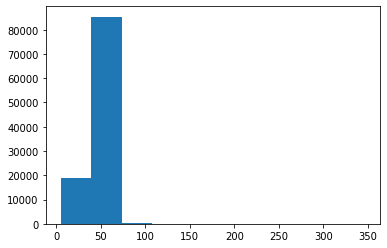

In [ ]:
# Соберём все размеры последовательностей
lenths = [len(sent) for sent in tokenized_texts]
# Посмотрим, как они распределяются
plt.hist(lenths)

In [ ]:
# Выравниваем датасет. Возьмём размер, равный 24
input_ids = pad_sequences(
    input_ids,
    # максимальная длина предложения
    maxlen=24,
    dtype='long',
    truncating='post',
    padding='post'
)

In [ ]:

# Вот, что у нас в результате получилось
# Как видно, в этом примере меньше 24 токенов, поэтому в конец был добавлен паддинг
input_ids[42]
     

array([  101,  1195, 14150, 29747, 29747, 23483,  1187, 10260, 29740,
       29436, 14150, 23925, 10325, 16856, 19259, 10260, 29436, 10260,
        1195, 15290, 29744, 14150, 29436, 29757])

In [ ]:

# Создадим маску внимания для каждого сэмпла обучающей выборки.
# единицами отметим те токены, которые нужно учитывать при обучении и вычислении градиентов,
# нулями - те, которые следует пропустить.
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [ ]:

print(attention_masks[42])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# каждая маска соответсвует своей последовательности
assert len(input_ids[42]) == len(attention_masks[42])

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_category, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [ ]:
assert len(train_inputs) == len(train_labels) == len(train_masks)
assert len(validation_inputs) == len(validation_labels) == len(validation_masks)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import SequentialSampler

In [ ]:
# специальная обёртка для работы с Тензор-датасетами, в Pytorch есть и другие,
# также можно и свою обёртку написать, для нашей же задачи вполне хватит уже существующих
# в библиотеке инструментов. Используя их мы существенно сокращаем свой код.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    # Данные по батчам разбиваем произвольно с помощью RandomSampler
    sampler=RandomSampler(train_data),
    batch_size=64
)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=64
)

In [ ]:
config = AutoConfig.from_pretrained("Out_Bert_Pretrained/checkpoint-2500",
                                    num_labels=len(category_index),
                                    id2label=category_index_reverce,
                                    label2id=category_index)

In [ ]:
#Загружаем модель, передаём ей наш конфиг
model = AutoModelForSequenceClassification.from_pretrained("Out_Bert_Pretrained/checkpoint-2500", config=config)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

In [ ]:
# Отправим на видеокарту, заодно посмотрим архитектуру нашего Берта
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elemen

In [ ]:
# Гипепараметры модели. Их можно изменять
param_optimizer = list(model.named_parameters())

In [ ]:
# Можно посмотреть или изменить. Но нам этого не нужно, инициализируем лишь функцию
# оптимизации. В качестве оптимизатора будем использовать оптимизированный 
# Adam (adaptive moment estimation)
# for name, _ in param_optimizer:
#     print(name)

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elemen

In [ ]:
%%time
train_loss_set = []
train_loss = 0

# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # Переводим данные на видеокарту
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    # Обнуляем градиенты
    optimizer.zero_grad()
    
    # Прогоняем данные по слоям нейросети
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Обратный прогон
    loss[0].backward()
    
    # Шаг
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    #print(f'Loss: {loss[0].item()}')
print('*'*20)
print(f'Лосс на обучении: {train_loss / len(train_dataloader)}')

********************
Лосс на обучении: 1.5499461679231552
CPU times: user 34.5 s, sys: 222 ms, total: 34.8 s
Wall time: 34.9 s


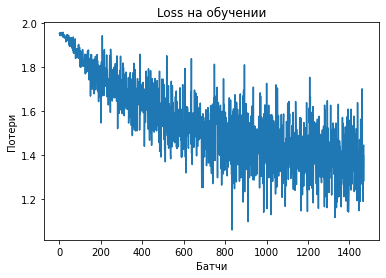

In [ ]:
# посмотрим, как обучалась наша модель
plt.plot(train_loss_set)
plt.title("Loss на обучении")
plt.xlabel("Батчи")
plt.ylabel("Потери")
plt.show()

In [ ]:
%time

# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch

    
    
    # Вычислять градиенты не нужно
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем логиты и метки на CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids #np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [ ]:
print(classification_report(valid_labels, valid_preds, target_names=['Все', 'Политика', 'Общество', 'Украина', 'Происшествия',
       'Госэкономика', 'Футбол']))

              precision    recall  f1-score   support

         Все       0.60      0.51      0.55      1472
    Политика       0.60      0.62      0.61      1489
    Общество       0.73      0.68      0.70      1555
     Украина       0.34      0.30      0.32      1428
Происшествия       0.47      0.48      0.48      1527
Госэкономика       0.40      0.65      0.50      1524
      Футбол       0.59      0.39      0.47      1453

    accuracy                           0.52     10448
   macro avg       0.53      0.52      0.52     10448
weighted avg       0.53      0.52      0.52     10448



Сохранение и загрузка дообученной модели

In [ ]:
model.save_pretrained('Bert')
tokenizer.save_pretrained('Bert')

('Bert/tokenizer_config.json',
 'Bert/special_tokens_map.json',
 'Bert/vocab.txt',
 'Bert/added_tokens.json')

In [ ]:
# config
config = AutoConfig.from_pretrained('Bert')
# tokenizer
tokenizer = AutoTokenizer.from_pretrained('Bert', pad_to_max_length=True)
# model
model = AutoModelForSequenceClassification.from_pretrained('Bert', config=config)

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elemen

In [ ]:
%%time

model.to('cpu')
model.eval()

# Выберем несколько случайных названий товаров
skus = [randint(1, len(df)) for p in range(0, 10)]
for sku in skus:
    ground_truth = df.iloc[sku]['category_1']
    sku_title = df.iloc[sku]['name']
    tokens = tokenizer.encode(sku_title, add_special_tokens=True)
    tokens_tensor = torch.tensor([tokens])
    with torch.no_grad():
        logits = model(tokens_tensor)
    # Логиты по каждой категории
    logits = logits[0].detach().numpy()
    # Выбираем наиболее вероятную категорию товара
    predicted_class = np.argmax(logits, axis=1)

    print(f'Название статьи: {sku_title}')
    print(f'Предсказанная категория: {category_index_reverce[predicted_class[0]]}')
    print(f'Истинная категория: {ground_truth}')
    print()

Название статьи: Главу Госкомстата Туркмении уволили за приукрашивание действительности
Предсказанная категория: Все
Истинная категория: Все

Название статьи: Пенсии россиян снова «заморозят»
Предсказанная категория: Общество
Истинная категория: Госэкономика

Название статьи: Граждане ЕС выбрали сторону в войне США с Россией
Предсказанная категория: Общество
Истинная категория: Политика

Название статьи: ЦБ назвал причину сокращения резервов России 
Предсказанная категория: Госэкономика
Истинная категория: Госэкономика

Название статьи: Правозащитники подсчитали число современных рабов
Предсказанная категория: Общество
Истинная категория: Общество

Название статьи: В России захотели взимать плату за вывоз мусора по-новому
Предсказанная категория: Общество
Истинная категория: Госэкономика

Название статьи: Малайзия разочаровалась в расследовании гибели своего «Боинга» в Донбассе
Предсказанная категория: Происшествия
Истинная категория: Политика

Название статьи: Лайнер со 150 пассажирам